# 2-4. KODEX 코스닥 150 월별 절대모멘텀

In [1]:
import pandas as pd
import numpy as np

### 함수

In [2]:
def 월별수익(data):
    result = data/data.shift(1)
    return result

def 절대모멘텀(data,month):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = np.where(data/data.shift(month)>1,1,0)
    return result

def CAGR(data):
    y = data.index.year.unique()
    result = (data[-1]/data[0])**(1/len(y))-1
    return np.round(result,4)

def MDD(data):
    # We are going to use a trailing 252 trading day window
    window = len(data)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = data.rolling(window, min_periods=1).max()
    Roll_Max.rename("Roll_Max", inplace=True)
    Drawdown = data/Roll_Max - 1.0
    Drawdown.rename("Drawdown", inplace=True)

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Drawdown = Drawdown.rolling(window, min_periods=1).min()
    Max_Drawdown.rename("Max_Drawdown", inplace=True)
    
    return np.round(Drawdown,4), np.round(Max_Drawdown,4)

# Main

### csv 파일 읽어오기

In [3]:
df = pd.read_csv("KODEX코스닥150_monthly_data.csv",encoding="utf-8", engine="python")

### Index는 datetime 형으로 변환하기

In [4]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Volume,Change
Date,,,,,,,
2015-10-30,2015-10-30,10629,10629,10452,10458,231953,-0.015347
2015-11-30,2015-11-30,10879,10879,10713,10787,329716,-0.003234
2015-12-31,2015-12-31,10678,10820,10634,10822,395520,0.018445
2016-01-29,2016-01-29,11075,11080,10938,11083,416093,0.004077
2016-02-29,2016-02-29,10197,10255,10137,10257,630334,0.005884


### 누적수익률 구하기, 학습하기

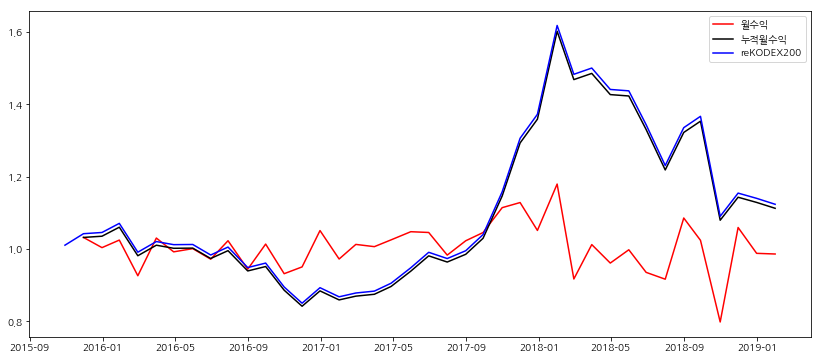

In [5]:
KODEX200 = df["Close"]
KODEX200.rename("KODEX200", inplace=True)
#KODEX200 re-scale 1.01
reKODEX200 = KODEX200/KODEX200.iloc[0] * 1.01
월수익 = 월별수익(KODEX200)

누적월수익 = 월수익.cumprod()

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐을 해결
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")  # 한글폰트 깨짐을 해결

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(월수익,color="Red", label="월수익")
ax.plot(누적월수익,color="Black", label="누적월수익")
ax.plot(reKODEX200,color="Blue", label="reKODEX200")
ax.legend();
#그래프는 누적수일률 값을 1.01부터 시작하게 하여 구분하였다.
#누적수익그래프와 종가그래프 100%로 일치한다.
#월별수익그래프 각 달의 수익이다.

### 개월수별 절대모멘텀 값 구하기, CAGR/MDD 구하기

In [6]:
KODEX코스닥150 = df["Close"]
KODEX코스닥150.rename("KODEX코스닥150", inplace=True)
KODEX코스닥150 = KODEX코스닥150/KODEX코스닥150[0] * 1  #re-scale로 1로 맞춤
자본 = 1  # re-scale과 같은 값으로 일치시킴

KODEX코스닥150_CAGR = CAGR(KODEX코스닥150) # CAGR 구하기
KODEX코스닥150_DD,KODEX코스닥150_MDD  = MDD(KODEX코스닥150)  # MDD 구하기
누적월별수익 = 월별수익(KODEX코스닥150).cumprod()  #누적수익률 구하기
print ("KODEX코스닥150 CAGR {:.2%} ".format(KODEX코스닥150_CAGR))
print ("KODEX코스닥150 MDD {:.2%}".format(KODEX코스닥150_MDD.min()))
print ("누적월별수익 {:.2%}".format(누적월별수익[-1]))
print ("")

i2name = {1:"개월1",2:"개월2",3:"개월3",4:"개월4",5:"개월5",6:"개월6",
         7:"개월7",8:"개월8",9:"개월9",10:"개월10",11:"개월11",12:"개월12"}
결과 = KODEX코스닥150.copy()

KODEX코스닥150 CAGR 2.15% 
KODEX코스닥150 MDD -32.64%
누적월별수익 111.21%



#### 절대모멘텀  3월이 '0'이상 이라면 4월 월수익을 사용한다. ? 3월 월수익은 2월달 투입금액의 수익이다.

In [7]:
월수익 = 월별수익(KODEX코스닥150)
result = pd.Series([np.round(KODEX코스닥150_CAGR*100,2),np.round(KODEX코스닥150_MDD.min()*100,2),np.round(누적월별수익.dropna()[-1]*100,2)],index=["절대CAGR","절대MDD","누적월별수익"], name="KODEX코스닥150")
for i in range(1,13):
    # 절대모멘텀 결과값을 오른쪽을 shift한다. 이렇게 해야 투입 달, 다음달 수익률 곱으로 계산된다.
    # 시계열 입력/결과 출력의 date index를 맞추게 된다.
    모멘텀점수 = pd.Series(절대모멘텀(KODEX코스닥150,i)).shift(1)
    누적월별수익 = 월수익[모멘텀점수.values == 1].cumprod()  #블린 인덱스후 월별수익은 누적곱으로 구한다.
    절대 = 누적월별수익 * 자본; 절대.rename(i2name[i], inplace=True)
    결과 = pd.concat([결과, 절대],axis=1)
    절대CAGR = CAGR(절대.dropna())
    절대DD, 절대MDD = MDD(절대)
    i2name[i] = pd.Series([np.round(절대CAGR*100,2), np.round(절대MDD.min()*100,2), np.round(누적월별수익.dropna()[-1]*100,2)], index=["절대CAGR","절대MDD","누적월별수익"], name=i)
    result = pd.concat([result,i2name[i]],axis=1)

In [8]:
result

,KODEX코스닥150,1,2,3,4,5,6,7,8,9,10,11,12
절대CAGR,2.15,-0.07,5.77,7.46,26.03,11.90,14.08,9.10,12.45,18.51,5.83,4.68,4.68
절대MDD,-32.64,-29.04,-27.12,-28.97,-11.18,-16.97,-16.97,-23.95,-23.95,-23.95,-32.64,-32.64,-32.64
누적월별수익,111.21,100.04,128.18,114.85,162.77,138.93,148.56,126.12,124.24,137.99,110.05,112.01,107.66


In [9]:
결과.head()

,KODEX코스닥150,개월1,개월2,개월3,개월4,개월5,개월6,개월7,개월8,개월9,개월10,개월11,개월12
Date,,,,,,,,,,,,,
2015-10-30,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-30,1.031459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,1.034806,1.003245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-29,1.059763,1.027440,1.024118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,0.980780,0.950867,0.947792,0.925471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 그래프 그리기

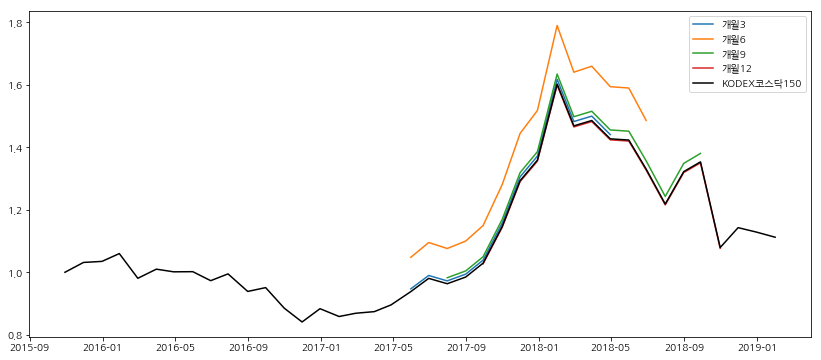

In [24]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
#ax.plot(결과["1개월"]);
ax.plot(결과["개월3"]);
ax.plot(결과["개월6"]);
ax.plot(결과["개월9"]);
ax.plot(결과["개월12"]);
ax.plot(KODEX코스닥150,color="Black", label="KODEX코스닥150");
ax.legend();

### Monthly MDD & Max MDD

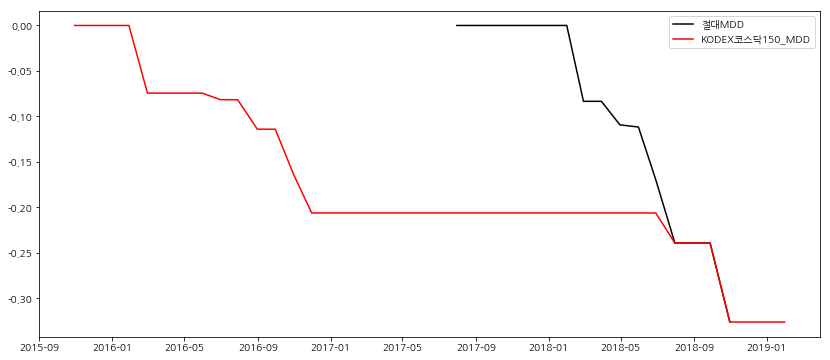

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

%matplotlib inline

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,1,1)
ax.plot(절대MDD,color="Black",label="절대MDD");
ax.plot(KODEX코스닥150_MDD,color="Red", label="KODEX코스닥150_MDD");
ax.legend()